#DualPol Demo

<b>Author</b><br>
Timothy Lang, NASA MSFC<br>
timothy.j.lang@nasa.gov

<b>Overview</b><br>
DualPol is a software module that works in Python 2 or 3. It provides a workflow for using CSU_RadarTools and Py-ART together to perform all-in-one retrievals from polarimetric radar data.

Before getting started, you will need to install the following:
<ul>
<li>A robust version of Python 2.7 or 3.4 (other versions untested) w/ most standard scientific packages (e.g., numpy, matplotlib, pandas, etc.) - Get one for free here: https://store.continuum.io/cshop/anaconda/</li>
<li>The Python Atmospheric Radiation Measurement (ARM) Radar Toolkit (Py-ART; https://github.com/ARM-DOE/pyart)</li>
<li>CSU_RadarTools (https://github.com/CSU-Radarmet/CSU_RadarTools) - a Python 3 version can be found here: https://github.com/tjlang/CSU_RadarTools</li>
<li>SkewT (https://pypi.python.org/pypi/SkewT) - a Python 3 version can be found here: https://github.com/tjlang/SkewT</li>
</ul>

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pyart
import dualpol
%matplotlib inline

Let's define where the sample data can be found.

In [2]:
fdir = '/Users/tjlang/Documents/OVWST/CPOL/output/20060119/'
files = sorted(glob.glob(fdir+'*nc'))
for file in files:
    print(os.path.basename(file))
radar = pyart.io.read(files[0])
print(radar.fields.keys())
print(radar.latitude['data'], radar.longitude['data'], radar.altitude['data'])

cfrad.20060119_170029.000_to_20060121_020810.000_CPOL_v1_PPI.nc
cfrad.20060119_170029.000_to_20060121_020810.000_CPOL_v1_PPI.nc_evad_rdy.nc
dict_keys(['SR', 'PH', 'RH', 'AH', 'AD', 'PF', 'KD', 'HD', 'ZC', 'DZ', 'ZD', 'DC', 'FL', 'VR'])
[-12.24916233] [ 131.04444878] [ 50.]


And now we can execute the dualpol retrievals with one (albeit long) line of code:

In [3]:
sndfile = '/Users/tjlang/Documents/OVWST/CPOL/soundings/snd_Darwin.txt'
retrieve = dualpol.DualPolRetrieval(files[0], dz='ZC', dr='ZD', kd='KD', rh='RH',
                                    use_temp=True, band='C', fhc_method='hybrid', 
                                    sounding=sndfile, fhc_T_factor=2,
                                    ice_flag=True, rain_method='hidro')

Let's print out the fields again to see what all was added:

In [4]:
print(retrieve.radar.fields.keys())

dict_keys(['FH', 'RH', 'MI', 'AH', 'AD', 'ZD', 'KD', 'ZC', 'DZ', 'method', 'MU', 'DC', 'FL', 'VR', 'SR', 'PH', 'NW', 'PF', 'D0', 'HD', 'MW', 'rain'])


And now a quick plot to show the results. Note how dualpol provides special color tables to simplify plotting of hydrometeor ID and rainfall method information.

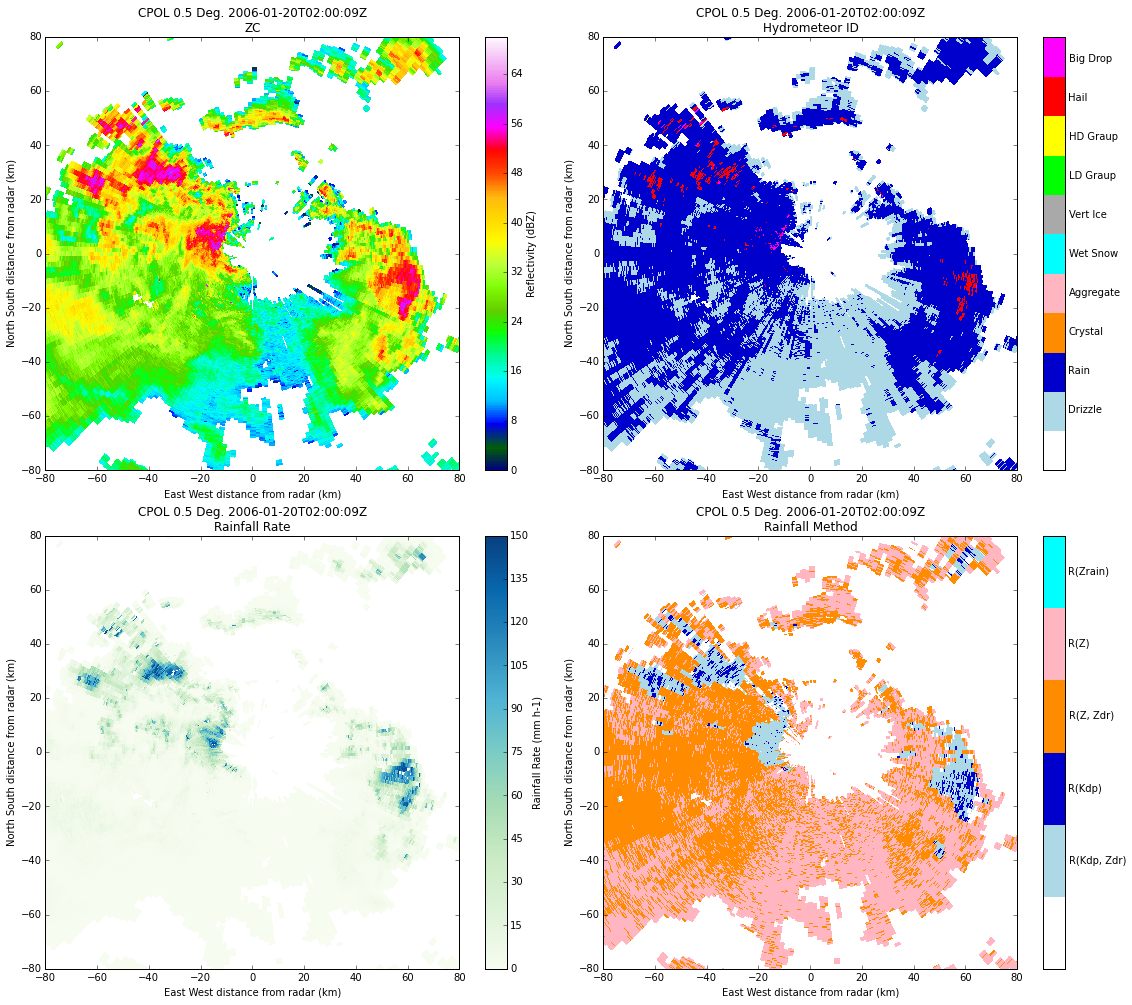

In [5]:
display = pyart.graph.RadarDisplay(retrieve.radar)
swp = 0
lim = [-80, 80]
fig = plt.figure(figsize=(16, 14))
ax1 = fig.add_subplot(221)
display.plot_ppi('ZC', swp, vmin=0, vmax=70, cmap='gist_ncar')
display.cbs[0].ax.set_ylabel('Reflectivity (dBZ)')
display.set_limits(xlim=lim, ylim=lim)
ax2 = fig.add_subplot(222)
hidcolor = dualpol.HidColors()
display.plot_ppi('FH', swp, vmin=0, vmax=10, cmap=hidcolor.cmaphid)
display.cbs[1] = hidcolor.adjust_fhc_colorbar_for_pyart(display.cbs[1])
display.set_limits(xlim=lim, ylim=lim)
ax3 = fig.add_subplot(223)
display.plot_ppi('rain', swp, vmin=0, vmax=150, cmap='GnBu')
display.set_limits(xlim=lim, ylim=lim)
ax4 = fig.add_subplot(224)
display.plot_ppi('method', swp, vmin=0, vmax=5, cmap=hidcolor.cmapmeth)
display.cbs[3] = hidcolor.adjust_meth_colorbar_for_pyart(display.cbs[3])
display.set_limits(xlim=lim, ylim=lim)
plt.tight_layout()

And let's print out the docstrings to find out more info.

In [6]:
help(dualpol)

Help on module dualpol:

NAME
    dualpol

DESCRIPTION
    Title/Version
    -------------
    Python Interface to Dual-Pol Radar Algorithms (DualPol)
    DualPol v0.8
    Developed & tested with Python 2.7 and 3.4
    Last changed 08/07/2015
    
    
    Author
    ------
    Timothy Lang
    NASA MSFC
    timothy.j.lang@nasa.gov
    (256) 961-7861
    
    
    Overview
    --------
    This is an object-oriented Python module that facilitates precipitation
    retrievals (e.g., hydrometeor type, precipitation rate, precipitation mass,
    particle size distribution information) from polarimetric radar data. It
    leverages existing open source radar software packages to perform all-in-one
    retrievals that are then easily visualized or saved using existing software.
    
    To access this module, add the following to your program and then make sure
    the path to this script is in your PYTHONPATH:
    import dualpol
    
    
    Notes
    -----
    Dependencies: numpy, pyart,